# Feature Importances for PA classifier

In this notebook, we discuss feature importances for PA classification. By an analysis of feature importances, we conclude that random forest is the best model for roc auc score, compared to logistic regression, support vector classifier, decision tree, AdaBoost, and voting classifier.

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
import dataframe_image as dfi
import upsetplot

sns.set_theme(style='whitegrid')

# import utils for loading data
# see `load_tables` in utils.py
import utils

## Drop-Feature Importance

Given a set of features $F$, a model $M$, dataset $D$, and a scoring function $s$, we define for each feature $f \in F$ its drop-feature importance as
$$DFI(f) = s(M(F, D)) - s(M(F', D)),$$
where $F' = F\backslash \{f\}$ is the subset of $F$ removing $f$, and $M(F, D)$ is the model $M$ on feature set $F$ trained on dataset $D$.

From the formula, $DFI(f)$ depends on the feature set $F$, the model $M$, dataset $D$ and also the scoring function $s$.

We have evaluated a list of models on all possible feature subsets in the [PA classification notebook](./pa_classifier.ipynb). We can use it to compute the drop-feature importance.

In [2]:
model_eval_path = os.path.join(utils.DATA_FOLDER, 'model_evals.csv')
df_evals = pd.read_csv(model_eval_path)

# make sense of fid
num_cols = ['correct_diagnosis', 'tried_and_failed', 'contraindication', 'random']
cat_cols = ['bin', 'drug']
all_cols = cat_cols + num_cols

subsets = []
for fid in range(2 ** len(all_cols)):
    fid_bin = [(fid >> i) & 1 for i in range(len(all_cols))]
    subsets.append(fid_bin)

df_features = pd.DataFrame(
    data=subsets, columns=all_cols
).reset_index().rename(columns={'index': 'fid'})

df_evals = pd.merge(df_evals, df_features, on='fid', how='left')

df_evals.sample(5, random_state=614)

,fid,model,data_type,score_func,score,bin,drug,correct_diagnosis,tried_and_failed,contraindication,random
3649,41,Decision Tree,validation,precision,0.749495,1,0,0,1,0,1
5340,60,SVC,train,accuracy,0.739523,0,0,1,1,1,1
6444,51,Bayes,test,roc_auc,0.500000,1,1,0,0,1,1
5244,59,Logistic,train,f1,0.832639,1,1,0,1,1,1
6496,55,Bayes,train,precision,1.000000,1,1,1,0,1,1


Reading the table above, take the 4th row as an example, it says the f1 score of the logistic regression on the training data is 0.832639, when trained using feature set [`bin`, `drug`,`tried_and_failed`, `contraindication`, `random`]. All models are always trained on the train data.

In [3]:
def drop_feature_importance(
    models, data_type='validation',
    score_func='roc_auc', include_random=True):
    '''Compute importance of a feature by dropping it.
    
    The baseline model use all available features. Then the importance of the
    feature X is computed by the difference of the score between the baseline model
    and the model without the feature X.
    '''
    if type(models) is str:
        models = [models]
    models = list(models)
    if 'Baseline' in models:
        models.remove('Baseline')
    fil = df_evals.model.isin(models) & (df_evals.data_type == data_type)
    fil = fil & (df_evals.score_func == score_func)
    df = df_evals[fil]
    
    n_col = len(all_cols)
    if not include_random:
        n_col -= 1
    
    fid_all = (1 << n_col) - 1
    feat_mask = [fid_all ^ (1 << i) for i in range(n_col)]
    
    data = []
    for model in models:
        baseline = df[(df.fid == fid_all) & (df.model == model)].score.tolist()[0]
        imp = []
        for mask in feat_mask:
            s = df[(df.fid == mask) & (df.model == model)].score.tolist()[0]
            imp.append(baseline - s)
        data.append(imp)
    df = pd.DataFrame(data=data, columns=all_cols[:n_col], index=models)
    
    return df

Let's take a look at the feature importances by accuracy.

In [4]:
drop_feature_importance(
    df_evals.model.unique(),
    score_func='accuracy',
    include_random=False
)

,bin,drug,correct_diagnosis,tried_and_failed,contraindication
Logistic,0.005239,-0.002721,0.019179,-0.018752,0.039257
SVC,0.005711,-0.002248,-0.004812,0.006565,0.039842
Decision Tree,0.071207,0.062056,-0.000922,0.005531,0.032130
Random Forest,0.071207,0.062056,-0.000922,0.005531,0.032130
Voting,0.053197,0.045238,-0.005733,-0.008814,0.037436
AdaBoost,-0.012703,-0.022596,0.000719,0.002046,0.019381
Bayes,0.071207,0.062056,-0.000922,0.005531,0.032130


Decision tree and random forest give the same feature importances in this classification problem. When we use decision tree model, the most importance feature for accuracy is `bin`, and the least important one is `correct_diagnosis`. In fact, removing `correct_diagnosis` will improve the model performace on accuracy.

Using different scoring function will give different importances. Next, we will look at feature importances based on roc auc score.

In [5]:
model = 'Decision Tree'
scoring = 'roc_auc'
df_drop_imp = drop_feature_importance(
    model,
    score_func=scoring,
    include_random=False
)

df_drop_imp

,bin,drug,correct_diagnosis,tried_and_failed,contraindication
Decision Tree,0.16983,0.137612,-0.014918,-0.026949,-0.03761


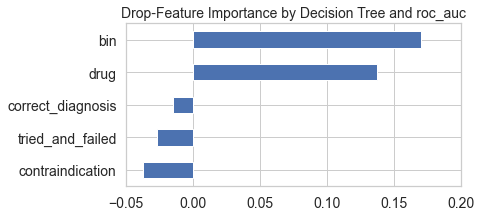

In [6]:
plt.figure(figsize=(6, 3))
df_drop_imp.loc[model, :].sort_values().plot(kind='barh', fontsize=14)
plt.title(f'Drop-Feature Importance by {model} and {scoring}', fontsize=14)
plt.xlim([-0.05, 0.20])
plt.show()

It shows a very different result than that using accuracy. We need to stress that **the feature importance only compare importances within a given feature set using a particular model and scoring function**. In this plot, we should say that to the decision tree model on the 5 features in the y-axis, the most important feature is `bin` if we care about roc auc score. The three features `correct_diagnosis`, `tried_and_failed` and `contraindication` actually decrease the roc auc score. Removing any of them will improve the model on the roc auc score, and removing `contraindication` improve the model the most.

In practice, we will include a random feature. The random feature then serves as a pivot feature for comparison. It will give us a better set of feature importances.

In [7]:
model = 'Decision Tree'
scoring = 'roc_auc'
df_drop_imp2 = drop_feature_importance(
    model,
    score_func=scoring,
    include_random=True
)

df_drop_imp2

,bin,drug,correct_diagnosis,tried_and_failed,contraindication,random
Decision Tree,0.146273,0.134037,0.004171,0.013742,0.033976,-0.019893


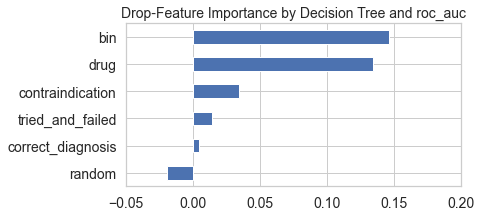

In [8]:
plt.figure(figsize=(6, 3))
df_drop_imp2.loc[model, :].sort_values().plot(kind='barh', fontsize=14)
plt.title(f'Drop-Feature Importance by {model} and {scoring}', fontsize=14)
plt.xlim([-0.05, 0.20])
plt.show()

Inclding the pivot feature `random` changes feature importances a lot, since the feature set is now different. `bin` and `drug` are still the two most important features, having large impact on the roc auc score. The three features `correct_diagnosis`, `tried_and_failed` and `contraindication` now positively impact on the score, which make more sense. Moreover, we can see `contraindication` is the third most important feature. This confirms our intuition, since `contraindication` indicates the treatment could do harm to patients.

Looking at the importances of features, we can also justify whether a model is good or not. If we care about roc auc score, decision tree is a good model, in a sense that it captures all important features such as `bin`, `drug` and `contraindication`.

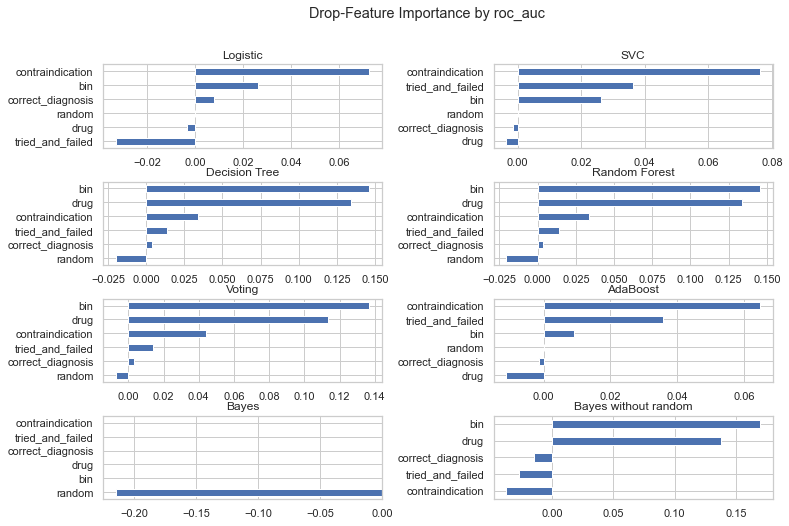

In [9]:
scoring = 'roc_auc'
models = df_evals.model.unique().tolist()
models.remove('Baseline')
df_drop_imp_all = drop_feature_importance(
    models,
    score_func=scoring,
    include_random=True
)

fig, axes = plt.subplots(4, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()
for model, ax in zip(models, axes):
    df_drop_imp_all.loc[model, :].sort_values().plot(kind='barh', ax=ax)
    ax.set_title(f'{model}')
fig.suptitle(f'Drop-Feature Importance by {scoring}')

model = 'Bayes'
scoring = 'roc_auc'
df_drop_imp3 = drop_feature_importance(
    model,
    score_func=scoring,
    include_random=False
)
df_drop_imp3.loc[model, :].sort_values().plot(kind='barh', ax=axes[-1])
axes[-1].set_title('Bayes without random')

plt.show()

According to feature importances, we see that decision tree, random forest and voting classifier are good models to make sense of roc auc scores. On the contrary, we conclude that logistic regression, support vector classifier (SVC) and AdaBoost are not good if we are interested in high roc auc scores, because they fail to capture importance features.

The Bayes optimal predictor is tricky. It can identify the `random` feature, but fails to compare feature importances with the `random` feature present. We plot feature importances for the Bayes optimal predictor without the `random` feature in the lower right corner. Just like the decision tree model, it decides that `contraindication` actually lowers the model's performance on roc auc score.

Among the good models, voting classifier is not as good as decision tree and random forest, in a way that its random feature has higher importance. To compare decision tree and random forest, we will look at confidence intervals of their feature importances.

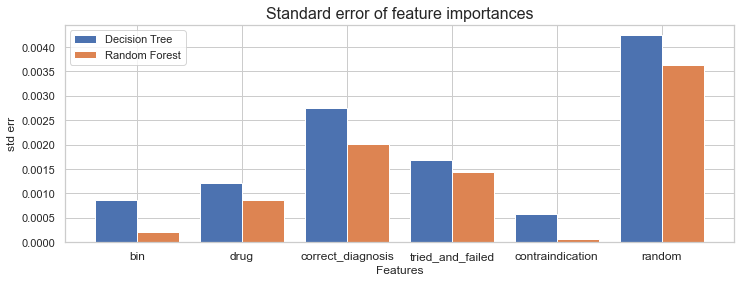

In [10]:
data_types = ['validation', 'test']
models = ['Decision Tree', 'Random Forest']
scoring = 'roc_auc'

df_drop_imp_ci = pd.concat([
    drop_feature_importance(
        models,
        data_type=dt,
        score_func=scoring,
        include_random=True,
    ) for dt in data_types
], axis=0)

x_axis = np.arange(df_drop_imp_ci.shape[1])
padding = 0.2
width = 2 * padding

plt.figure(figsize=(12, 4))
plt.bar(x_axis - padding, df_drop_imp_ci.loc['Decision Tree'].std(), width, label='Decision Tree')
plt.bar(x_axis + padding, df_drop_imp_ci.loc['Random Forest'].std(), width, label='Random Forest')

plt.xticks(x_axis, df_drop_imp_ci.columns, fontsize=12)
plt.xlabel('Features')
plt.ylabel('std err', fontsize=12)
plt.title('Standard error of feature importances', fontsize=16)

plt.legend()
plt.show()

Since standard errors are small compared to means of feature importances, it is hard to visualize the confidence intervals. However, the mean for each feature importance are close for decision tree and random forest, so we can just compare their standard errors. Standard errors are better if smaller.

Random forest has smaller standard errors for all features, so it is better than decision tree. However, keep in mind that the standard error for each importance is calculated by only two samples. We conclude that **random forest is the best model from this analysis of drop-feature importances, if we use roc auc as our scoring function**.